# Trending Data

# 0 - import lib, load data

## 0.0 - import libraries

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot, plot
from plotly.subplots import make_subplots

from IPython.core.display import HTML
from IPython.display import Image, Audio

%matplotlib inline
# Wrapper around pandas cut() method.
def my_cut (x, bins, lower_infinite=False, upper_infinite=False, **kwargs):
    """
    Wrapper around pandas cut() to create infinite lower/upper bounds with proper labeling.

    Takes all the same arguments as pandas cut(), plus two more.

    Args :
        lower_infinite (bool, optional) : set whether the lower bound is infinite
            Default is True. If true, and your first bin element is something like 20, the
            first bin label will be '<= 20' (depending on other cut() parameters)
        upper_infinite (bool, optional) : set whether the upper bound is infinite
            Default is True. If true, and your last bin element is something like 20, the
            first bin label will be '> 20' (depending on other cut() parameters)
        **kwargs : any standard pandas cut() labeled parameters

    Returns :
        out : same as pandas cut() return value
        bins : same as pandas cut() return value
    
    Code slidely modified from sparc_spread, StackOverflow: https://stackoverflow.com/a/30199132/1843511
    """

    # Quick passthru if no infinite bounds
    if not lower_infinite and not upper_infinite:
        return pd.cut(x, bins, **kwargs)

    # Setup
    num_labels      = len(bins) - 1
    include_lowest  = kwargs.get("include_lowest", False)
    right           = kwargs.get("right", True)

    # Prepend/Append infinities where indiciated
    bins_final = bins.copy()
    if upper_infinite:
        bins_final.insert(len(bins),float("inf"))
        num_labels += 1
    if lower_infinite:
        bins_final.insert(0,float("-inf"))
        num_labels += 1

    # Decide all boundary symbols based on traditional cut() parameters
    symbol_lower  = "<=" if include_lowest and right else "<"
    left_bracket  = "(" if right else "["
    right_bracket = "]" if right else ")"
    symbol_upper  = ">" if right else ">="

    # Inner function reused in multiple clauses for labeling
    def make_label(i, lb=left_bracket, rb=right_bracket):
        return "{0} - {1}".format(bins_final[i], bins_final[i+1])

    # Create custom labels
    labels=[]
    for i in range(0,num_labels):
        new_label = None

        if i == 0:
            if lower_infinite:
                new_label = "{0} {1}".format(symbol_lower, bins_final[i+1])
            elif include_lowest:
                new_label = make_label(i, lb="[")
            else:
                new_label = make_label(i)
        elif upper_infinite and i == (num_labels - 1):
            new_label = "{0} {1}".format(symbol_upper, bins_final[i])
        else:
            new_label = make_label(i)

        labels.append(new_label)

    # Pass thru to pandas cut()
    return pd.cut(x, bins_final, labels=labels, **kwargs)

## 0.1 - load data from file

In [ ]:
!ls

drive  sample_data


In [2]:
# Open file with the raw data
file = open('drive/Shareddrives/CIS519/archive/trending.json', encoding="utf8")

# Load data as JSON
raw_data = json.load(file)

# Close the original file
file.close()

# Select only the list with the video data
trending_videos_list = raw_data['collector']

# Example of a video object
print(json.dumps(trending_videos_list[15], indent=4, sort_keys=True))

{
    "authorMeta": {
        "avatar": "https://p77-sign-sg.tiktokcdn.com/tos-maliva-avt-0068/ce5595b5c4874a234d0e41feec9b4ef9~c5_1080x1080.jpeg?x-expires=1608649200&x-signature=HXQeWxkqcbcR2JEz9JRdZWOhJ%2Fw%3D",
        "id": "6563548229581422598",
        "name": "jhullyduarte",
        "nickName": "Jhully Duarte",
        "secUid": "MS4wLjABAAAAByNqbJCtA9PfwY1ICwGomesu7URs6GhushkQeWleqhqsTSRmCKKi1GpUXOWabnbI",
        "signature": "\ud83e\udd2a\ud83e\udd2a",
        "verified": false
    },
    "commentCount": 267,
    "covers": {
        "default": "https://p16-sign-sg.tiktokcdn.com/obj/tos-maliva-p-0068/6416d73acd5a47c0bb04c0982e4b973e?x-expires=1608584400&x-signature=qa5fI0p5HrD71YMq70ImAirJtzI%3D",
        "dynamic": "https://p16-sign-sg.tiktokcdn.com/obj/tos-maliva-p-0068/b45558f5231340cdbf9f34f5574cc98c_1608239182?x-expires=1608584400&x-signature=IWs7ofM62Z2%2FcvyxJhpYLZowafM%3D",
        "origin": "https://p16-sign-sg.tiktokcdn.com/obj/tos-maliva-p-0068/c137bcc58fcc4798b3052

The `explode()` function is used to transform each element of a list-like to a row, replicating the index values. 
So we would like to perform the following steps:

1. Set each column we would like to keep as index, temporarily.
2. Converting the comma separated values to a list
3. Create a new row for each value by using the `explode()` function, which copies all index fields as well
4. Resetting the index


In [3]:
# Create a DataFrame of the data
df_tiktok_dataset = pd.DataFrame(trending_videos_list)

# Let's expand the hashtag cell containing lists to multiple rows
df_tiktok_dataset = df_tiktok_dataset.explode('hashtags').explode('mentions')

In [4]:
def object_to_columns(dfRow, **kwargs):
    '''Function to expand cells containing dictionaries, to columns'''
    for column, prefix in kwargs.items():
        if isinstance(dfRow[column], dict):
            for key, value in dfRow[column].items():
                columnName = '{}.{}'.format(prefix, key)
                dfRow[columnName] = value
    return dfRow

# Expand certain cells containing dictionaries to columns
df_tiktok_dataset = df_tiktok_dataset.apply(object_to_columns, 
                            authorMeta='authorMeta',  
                            musicMeta='musicMeta',
                            covers='cover',
                            videoMeta='videoMeta',
                            hashtags='hashtag', axis = 1)

# Remove the original columns containing the dictionaries
df_tiktok_dataset = df_tiktok_dataset.drop(['authorMeta','musicMeta','covers','videoMeta','hashtags'], axis = 1)
df_tiktok_dataset

,authorMeta.avatar,authorMeta.id,authorMeta.name,authorMeta.nickName,authorMeta.secUid,authorMeta.signature,authorMeta.verified,commentCount,cover.default,cover.dynamic,cover.origin,createTime,diggCount,downloaded,hashtag.cover,hashtag.id,hashtag.name,hashtag.title,id,mentions,musicMeta.coverLarge,musicMeta.coverMedium,musicMeta.coverThumb,musicMeta.musicAuthor,musicMeta.musicId,musicMeta.musicName,musicMeta.musicOriginal,musicMeta.playUrl,playCount,shareCount,text,videoMeta.duration,videoMeta.height,videoMeta.width,videoUrl,videoUrlNoWaterMark,webVideoUrl
0,https://p16-sign-sg.tiktokcdn.com/aweme/1080x1...,6825540583826768902,ninakleij,Nina,MS4wLjABAAAA1FfFjRMUzr0hX2YPT7pRr7bCPQWa-kU_kV...,don’t tell my instagram I’m here\n19 👸🏼,False,68,https://p16-sign-sg.tiktokcdn.com/obj/tos-alis...,https://p16-sign-sg.tiktokcdn.com/obj/tos-alis...,https://p16-sign-sg.tiktokcdn.com/obj/tos-alis...,1608214517,3710,True,NaN,NaN,NaN,NaN,6907228749016714497,NaN,https://p77-sg.tiktokcdn.com/aweme/720x720/tos...,https://p77-sg.tiktokcdn.com/aweme/200x200/tos...,https://p77-sg.tiktokcdn.com/aweme/100x100/tos...,Pop Smoke,6790057285814061057,Element,False,https://sf16-sg.tiktokcdn.com/obj/tos-alisg-v-...,44800,50,Confidence went 📈,15,1024,576,https://v77.tiktokcdn.com/ed1f811617d7b5e18b8d...,,https://www.tiktok.com/@ninakleij/video/690722...
1,https://p16-sign-va.tiktokcdn.com/musically-ma...,6729292817489986566,joeysofo,JoeySofo,MS4wLjABAAAAvkCSTiPWJm7Ctqp7AN3mauS_Bi8tVrbtBg...,Tinder couldn’t help me lose my virginity so I...,False,936,https://p16-sign-sg.tiktokcdn.com/obj/tos-mali...,https://p16-sign-sg.tiktokcdn.com/obj/tos-mali...,https://p16-sign-sg.tiktokcdn.com/obj/tos-mali...,1600819763,55700,True,NaN,NaN,NaN,NaN,6875468410612993286,@dwight_schnuute,https://p77-sign-sg.tiktokcdn.com/musically-ma...,https://p77-sign-sg.tiktokcdn.com/musically-ma...,https://p16-sign-sg.tiktokcdn.com/musically-ma...,rapidsongs,6678927595137977094,Without Me,True,https://sf77-sg.tiktokcdn.com/obj/musically-ma...,838100,1817,Quiet Zone... follow me on insta: joeysofo. Co...,11,1024,576,https://v77.tiktokcdn.com/ab935f1975cb8b69aebf...,,https://www.tiktok.com/@joeysofo/video/6875468...
2,https://p16-sign-sg.tiktokcdn.com/aweme/1080x1...,6791901371429913601,jackeyephone,JackJacko,MS4wLjABAAAAsI8XQOceYtnIhIbLZLhvz24tOWdWYavlPe...,Zakelijk 📩 jackeyephone@gmail.com\nInstagram: ...,False,27100,https://p16-sign-sg.tiktokcdn.com/obj/tos-alis...,https://p16-sign-sg.tiktokcdn.com/obj/tos-alis...,https://p16-sign-sg.tiktokcdn.com/obj/tos-alis...,1606228625,936200,True,,23428,tiktok,,6898699405898059010,NaN,https://p77-sg.tiktokcdn.com/aweme/720x720/tos...,https://p77-sg.tiktokcdn.com/aweme/200x200/tos...,https://p77-sg.tiktokcdn.com/aweme/100x100/tos...,Sigurd Barrett,6881287666340481026,Pilfingerdansen - Remix,False,https://sf16-sg.tiktokcdn.com/obj/tos-alisg-v-...,15300000,21100,Iphone bend test🤗 #tiktok #viral #fyp #iphone ...,19,960,540,https://v21.tiktokcdn.com/video/tos/alisg/tos-...,,https://www.tiktok.com/@jackeyephone/video/689...
2,https://p16-sign-sg.tiktokcdn.com/aweme/1080x1...,6791901371429913601,jackeyephone,JackJacko,MS4wLjABAAAAsI8XQOceYtnIhIbLZLhvz24tOWdWYavlPe...,Zakelijk 📩 jackeyephone@gmail.com\nInstagram: ...,False,27100,https://p16-sign-sg.tiktokcdn.com/obj/tos-alis...,https://p16-sign-sg.tiktokcdn.com/obj/tos-alis...,https://p16-sign-sg.tiktokcdn.com/obj/tos-alis...,1606228625,936200,True,,20884,viral,,6898699405898059010,NaN,https://p77-sg.tiktokcdn.com/aweme/720x720/tos...,https://p77-sg.tiktokcdn.com/aweme/200x200/tos...,https://p77-sg.tiktokcdn.com/aweme/100x100/tos...,Sigurd Barrett,6881287666340481026,Pilfingerdansen - Remix,False,https://sf16-sg.tiktokcdn.com/obj/tos-alisg-v-...,15300000,21100,Iphone bend test🤗 #tiktok #viral #fyp #iphone ...,19,960,540,https://v21.tiktokcdn.com/video/tos/alisg/tos-...,,https://www.tiktok.com/@jackeyephone/video/689...
2,https://p16-sign-sg.tiktokcdn.com/aweme/1080x1...,6791901371429913601,jackeyephone,Jac

In [5]:
df_tiktok_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5693 entries, 0 to 999
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   authorMeta.avatar        5693 non-null   object
 1   authorMeta.id            5693 non-null   object
 2   authorMeta.name          5693 non-null   object
 3   authorMeta.nickName      5693 non-null   object
 4   authorMeta.secUid        5693 non-null   object
 5   authorMeta.signature     5693 non-null   object
 6   authorMeta.verified      5693 non-null   bool  
 7   commentCount             5693 non-null   int64 
 8   cover.default            5693 non-null   object
 9   cover.dynamic            5693 non-null   object
 10  cover.origin             5693 non-null   object
 11  createTime               5693 non-null   int64 
 12  diggCount                5693 non-null   int64 
 13  downloaded               5693 non-null   bool  
 14  hashtag.cover            5540 non-null   

In [6]:
df_tiktok_dataset.describe()

,commentCount,createTime,diggCount,playCount,shareCount,videoMeta.duration,videoMeta.height,videoMeta.width
count,5693.000000,5.693000e+03,5.693000e+03,5.693000e+03,5693.000000,5693.000000,5693.000000,5693.000000
mean,701.559283,1.604877e+09,5.630986e+04,6.062278e+05,1481.563323,20.568066,977.729492,579.945547
std,8671.442272,2.282009e+06,4.927927e+05,4.554259e+06,8580.033748,14.964944,119.002955,78.260349
min,0.000000,1.600785e+09,1.300000e+01,4.650000e+02,0.000000,4.000000,352.000000,240.000000
25%,51.000000,1.602862e+09,3.090000e+03,4.710000e+04,20.000000,10.000000,960.000000,576.000000
50%,123.000000,1.604961e+09,7.320000e+03,8.190000e+04,82.000000,15.000000,1024.000000,576.000000
75%,370.000000,1.606932e+09,2.140000e+04,1.973000e+05,388.000000,25.000000,1024.000000,576.000000
max,625700.000000,1.608521e+09,3.100000e+07,2.508000e+08,220100.000000,60.000000,1248.000000,1248.000000


In [7]:
# Get unique rows from dataset
df_unique_videos = df_tiktok_dataset.drop_duplicates(subset='id', keep="first")
df_unique_music = df_tiktok_dataset.drop_duplicates(subset='musicMeta.musicId', keep="first")
df_unique_authors = df_tiktok_dataset.drop_duplicates(subset='authorMeta.id', keep="first")

# Show amount of rows per dataset
{
    'df_tiktok_dataset': df_tiktok_dataset.shape,
    'df_unique_videos': df_unique_videos.shape,
    'df_unique_music': df_unique_music.shape,
    'df_unique_authors': df_unique_authors.shape
}

{'df_tiktok_dataset': (5693, 37),
 'df_unique_authors': (802, 37),
 'df_unique_music': (907, 37),
 'df_unique_videos': (1000, 37)}

## Datasets to be analyzed further:


*   df_tiktok_dataset
*   df_unique_videos
*   df_unique_dataset
*   df_unique_videos


#1 - Data Analysis

## 1.0 - Histogram for every numerical feature

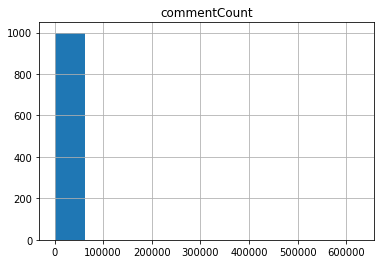

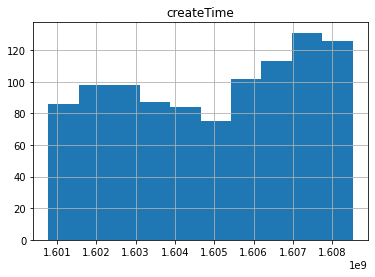

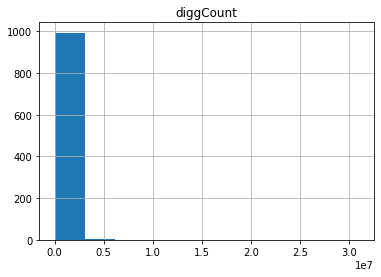

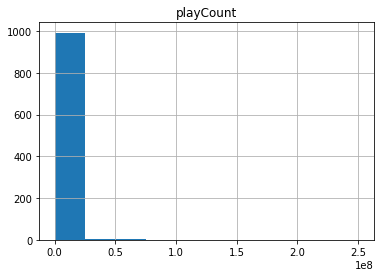

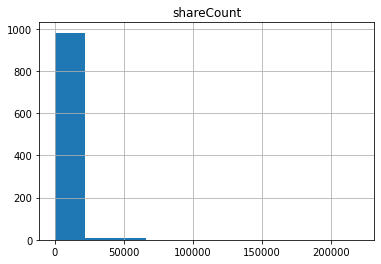

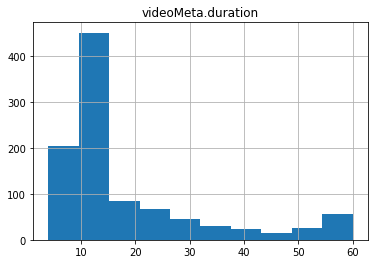

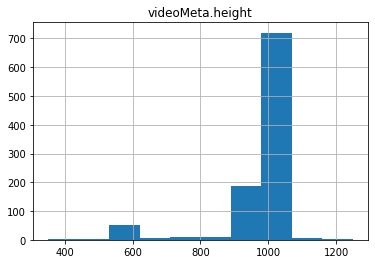

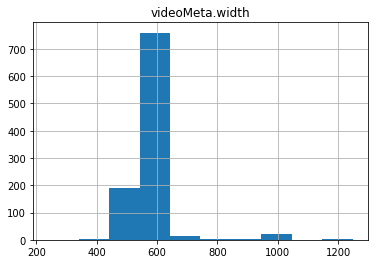

In [ ]:
for feature in df_unique_videos.describe().columns:
    df_unique_videos.hist(feature)

## 1.1 - Create time

In [8]:
from datetime import datetime

mean_create_time = datetime.fromtimestamp(round(df_unique_videos['createTime'].mean()))
min_create_time = datetime.fromtimestamp(df_unique_videos['createTime'].min())
max_create_time = datetime.fromtimestamp(df_unique_videos['createTime'].max())
print("earliest create time: ", min_create_time)
print("mean create time: ", mean_create_time)
print("lastest create time: ", max_create_time)

earliest create time:  2020-09-22 14:22:38
mean create time:  2020-11-09 12:23:38
lastest create time:  2020-12-21 03:18:36


In [19]:
dt_create_time = list(map(lambda x: datetime.fromtimestamp(x), df_unique_videos['createTime'].values))

In [21]:
print(dt_create_time[0])

2020-12-17 14:15:17


## 1.1.1 Create time versus likes

In [23]:
df_videos_users_focus = df_unique_videos[df_unique_videos['diggCount'] <= 50000]
dt_focus_create_time = list(map(lambda x: datetime.fromtimestamp(x), df_videos_users_focus['createTime'].values))

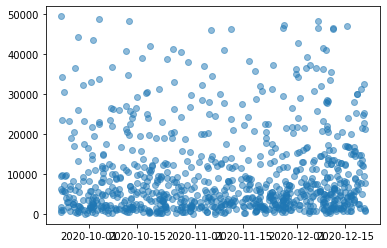

In [24]:
plt.scatter(dt_focus_create_time , df_videos_users_focus['diggCount'], alpha=0.5)

In [26]:
df_videos_users_focus.loc[:, 'dt_create_time'] = dt_focus_create_time

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [37]:
import datetime
start_date = datetime.date(2020, 9, 22)
end_date = datetime.date(2020, 12, 21)
delta = datetime.timedelta(days=1)
data = []
while start_date <= end_date:
    condition = (pd.to_datetime(start_date) <= df_videos_users_focus['dt_create_time']) & (df_videos_users_focus['dt_create_time'] <= pd.to_datetime(start_date + delta))
    data.append([start_date, df_videos_users_focus[condition]['diggCount'].mean()])
    start_date += delta

## 1.2 - Deep Dive into likes and comments

In [36]:
(pd.to_datetime(start_date) <= df_videos_users_focus['dt_create_time']) & (df_videos_users_focus['dt_create_time'] <= pd.to_datetime(start_date + delta))

0      False
3      False
4      False
6      False
7      False
       ...  
994    False
995    False
996    False
997    False
998    False
Name: dt_create_time, Length: 859, dtype: bool

In [39]:
df_videos_users_focus[condition]

,authorMeta.avatar,authorMeta.id,authorMeta.name,authorMeta.nickName,authorMeta.secUid,authorMeta.signature,authorMeta.verified,commentCount,cover.default,cover.dynamic,cover.origin,createTime,diggCount,downloaded,hashtag.cover,hashtag.id,hashtag.name,hashtag.title,id,mentions,musicMeta.coverLarge,musicMeta.coverMedium,musicMeta.coverThumb,musicMeta.musicAuthor,musicMeta.musicId,musicMeta.musicName,musicMeta.musicOriginal,musicMeta.playUrl,playCount,shareCount,text,videoMeta.duration,videoMeta.height,videoMeta.width,videoUrl,videoUrlNoWaterMark,webVideoUrl,dt_create_time


In [ ]:
df_unique_videos['diggCount'].describe()

count    1.000000e+03
mean     9.679788e+04
std      1.043487e+06
min      1.300000e+01
25%      2.864500e+03
50%      7.412500e+03
75%      2.285000e+04
max      3.100000e+07
Name: diggCount, dtype: float64

In [ ]:
# Set bucket ranges
buckets = list(range(0,105000,5000))

# Count videos with likes and comments per bucket range
likes = df_unique_videos.groupby( my_cut( df_unique_videos['diggCount'], buckets, upper_infinite=True ) ).diggCount.count()
comments = df_unique_videos.groupby( my_cut( df_unique_videos['commentCount'], buckets, upper_infinite=True ) ).diggCount.count()

# Transform from series to dataframe with some small modifications
likes = likes.rename('likes').to_frame().reset_index() 
comments = comments.rename('comments').to_frame().reset_index() 

# create subplots, two rows and 1 column each row
fig = make_subplots(2,1,subplot_titles=("Distribution of Likes", "Distribution of Comments"))

# First plot
fig.add_trace(
    go.Bar(y = likes['diggCount'], 
           x = likes['likes'], 
           name="Likes",
           text = likes['likes'], 
           orientation='h',
           texttemplate='%{text:.2s}', 
           textposition='outside', 
           marker_color='rgb(162, 210, 255)'
    ),
    row=1,col=1
)

# Second plot
fig.add_trace(
    go.Bar(y = comments['commentCount'], 
           x = comments['comments'], 
           name="Comments",
           text = comments['comments'], 
           orientation='h',
           texttemplate='%{text:.2s}', 
           textposition='outside', 
           marker_color='rgb(205, 180, 219)'
    ),
    row=2,col=1
)

fig.update_layout(title_text="Multiple Subplots with Titles",
                  height=1200,
                  template='plotly_white',
                  margin=go.layout.Margin(
                      l=130,r=5,b=5,t=100,pad=10
                  ))

fig.update_xaxes(title_text='Videos')
fig.update_yaxes(title_text='Likes', col=1, row=1, automargin=False)
fig.update_yaxes(title_text='Comments', col=1, row=2, automargin=False)

fig.show(config={'displayModeBar': False})

insight:
  1. most videos have likes and comments below 50000
  2. most videos have comments lie in the range 0 - 5000

In [ ]:
# Focus on dataset from 0 till 50.000 likes
df_videos_users_focus = df_unique_videos[df_unique_videos['diggCount'] <= 50000]

# Create a scatter plot with a trendline
fig = px.scatter(df_videos_users_focus, trendline="ols",
                 x="diggCount", 
                 y="commentCount",
                 labels={
                     "diggCount": "Likes",
                     "commentCount": "Comments"
                 },
                 log_y=True,
                 trendline_color_override="#ff7096", 
                 template='plotly_white')

fig.update_traces(marker=dict(
                     color='#4cc9f0',
                     opacity=0.6,
                 ))
fig.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



insight:
  1. positive correlation between likes and comments
  2. there isn't a video with more than 20000 likes with less than 50 comments

## 1.3 - Popular Hashtags

In [ ]:
# Create a DataFrame of the data
df_hashtags = pd.DataFrame(trending_videos_list)

# Let's expand the hashtag cell containing lists to multiple rows
df_hashtags = df_hashtags.explode('hashtags')

# Expand certain cells containing dictionaries to columns
df_hashtags = df_hashtags.apply(object_to_columns, 
                                hashtags='hashtag', axis = 1)

hashtags = df_hashtags[['hashtag.name']].copy().dropna()
hashtags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5330 entries, 2 to 999
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   hashtag.name  5330 non-null   object
dtypes: object(1)
memory usage: 83.3+ KB


In [ ]:
# Add column with default value
hashtags['count'] = 1

# Count all hashtags, group and replace the count column value with the sum
hashtags = hashtags.groupby(["hashtag.name"])["count"].count().reset_index()

# Sort by most popular hashtags and keep the top 15
hashtags = hashtags.sort_values(by='count', ascending=False)[:15]

# Set colours

# Create a Pie Chart with all values
fig = go.Figure(data=[go.Pie(
                        labels=hashtags["hashtag.name"], 
                        values=hashtags["count"], 
                        textinfo='label+percent'
                )], 
                layout={"colorway": ["#f72585","#b5179e",
                                     "#7209b7","#560bad",
                                     "#480ca8","#3a0ca3",
                                     "#3f37c9","#4361ee",
                                     "#4895ef","#4cc9f0"]})
fig.show()

## 1.4 - Audio Data Analysis

### 1.4.1 - Load Data

In [ ]:
# Import Audd Data
df_audd_music = pd.read_csv('../input/tiktok-trending-december-2020/audd/audd_music.csv', index_col='id')
df_audd_music_apple = pd.read_csv('../input/tiktok-trending-december-2020/audd/audd_music_apple_music.csv')
df_audd_music_spotify = pd.read_csv('../input/tiktok-trending-december-2020/audd/audd_music_spotify_music.csv')
df_audd_music_spotify_artists = pd.read_csv('../input/tiktok-trending-december-2020/audd/audd_music_spotify_music_artists.csv')

FileNotFoundError: ignored

In [ ]:
# The current version of the dataset contains duplicated rows, let's remove them
df_audd_music = df_audd_music.drop_duplicates()

# Add prefix to this dataset, before merging
df_audd_music = df_audd_music.add_prefix('_audd_music.')
df_audd_music.shape

In [ ]:
# Create a DataFrame of the data
df_tiktok_music = pd.DataFrame(trending_videos_list)

# Expand certain cells containing dictionaries to columns
df_tiktok_music = df_tiktok_music.apply(object_to_columns, 
                                        musicMeta='musicMeta', axis = 1)

# Convert the column dtype to int64 so we can merge
df_tiktok_music['musicMeta.musicId'] = df_tiktok_music['musicMeta.musicId'].astype('int64')
df_tiktok_music.shape

In [ ]:
df_tiktok_audd_music = df_tiktok_music.merge(df_audd_music, how='left', right_on='id', left_on='musicMeta.musicId')
df_tiktok_audd_music.shape

# 2 - Feature Extraction

## 2.1 - Audio Feature Extraction

### 2.1.1 - Cut Audio Feature into Frame

### 2.1.2 - Extract Audio Feature
The audio features are extracted from a
CNN architecture trained for audio classification

S. Hershey, S. Chaudhuri, D. P. W. Ellis, J. F. Gemmeke, A. Jansen,
C. Moore, M. Plakal, D. Platt, R. A. Saurous, B. Seybold, M. Slaney,
R. Weiss, and K. Wilson, “CNN architectures for large-scale audio
classification,” in International Conference on Acoustics, Speech and
Signal Processing (ICASSP), 2017

## 2.2 - Video Feature Extraction

### 2.2.1 - Cut Video into Frame

In [ ]:
from datetime import timedelta
import cv2
import numpy as np
import os

In [ ]:
SAVING_FRAMES_PER_SECOND = 1

In [ ]:
def format_timedelta(td):
    """Utility function to format timedelta objects in a cool way (e.g 00:00:20.05) 
    omitting microseconds and retaining milliseconds"""
    result = str(td)
    try:
        result, ms = result.split(".")
    except ValueError:
        return result + ".00".replace(":", "-")
    ms = int(ms)
    ms = round(ms / 1e4)
    return f"{result}.{ms:02}".replace(":", "-")


def get_saving_frames_durations(cap, saving_fps):
    """A function that returns the list of durations where to save the frames"""
    s = []
    # get the clip duration by dividing number of frames by the number of frames per second
    clip_duration = cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)
    # use np.arange() to make floating-point steps
    for i in np.arange(0, clip_duration, 1 / saving_fps):
        s.append(i)
    return s

def vid_to_frame(video_file, SAVING_FRAMES_PER_SECOND = 1):
    fn, _ = os.path.splitext(video_file)
    vid_id = fn[fn.rfind('/') + 1 :]
    loc = fn[0:(fn.rfind('/', 0, fn.rfind('/'))+1)]
    filename = loc + 'video_frame/' + vid_id
    # make a folder by the name of the video file
    if not os.path.isdir(filename):
        os.mkdir(filename)
    # read the video file    
    cap = cv2.VideoCapture(video_file)
    # get the FPS of the video
    fps = cap.get(cv2.CAP_PROP_FPS)
    # if the SAVING_FRAMES_PER_SECOND is above video FPS, then set it to FPS (as maximum)
    saving_frames_per_second = min(fps, SAVING_FRAMES_PER_SECOND)
    # get the list of duration spots to save
    saving_frames_durations = get_saving_frames_durations(cap, saving_frames_per_second)
    # start the loop
    count = 0
    while True:
        is_read, frame = cap.read()
        if not is_read:
            # break out of the loop if there are no frames to read
            break
        # get the duration by dividing the frame count by the FPS
        frame_duration = count / fps
        try:
            # get the earliest duration to save
            closest_duration = saving_frames_durations[0]
        except IndexError:
            # the list is empty, all duration frames were saved
            break
        if frame_duration >= closest_duration:
            # if closest duration is less than or equals the frame duration, 
            # then save the frame
            frame_duration_formatted = format_timedelta(timedelta(seconds=frame_duration))
            cv2.imwrite(os.path.join(filename, f"frame{frame_duration_formatted}.jpg"), frame) 
            # drop the duration spot from the list, since this duration spot is already saved
            try:
                saving_frames_durations.pop(0)
            except IndexError:
                pass
        # increment the frame count
        count += 1

In [ ]:
!rm -r ./drive/Shareddrives/CIS519/archive/video_frame

In [ ]:
from os import listdir
from os.path import isfile, join
files = [join('./drive/Shareddrives/CIS519/archive/videos', f) for f in listdir('./drive/Shareddrives/CIS519/archive/videos') if isfile(join('./drive/Shareddrives/CIS519/archive/videos', f))]

In [43]:
df1 = df_unique_videos.sort_values('diggCount',ascending = False).reset_index()

In [49]:
df1.loc[0:500, 'trending'] = True
df1.loc[500:, 'trending'] = False

In [51]:
label = df1[['trending', 'id']]

In [54]:
label.to_csv('label.csv')

Using the same extraction as youtubeM8
https://github.com/google/mediapipe/tree/master/mediapipe/examples/desktop/youtube8m

### 2.2.2 - Extract Video Feature
The visual features consist of ReLU activations of the last fully connected layer from a publicly available2
Inception network
trained on Imagenet

Inception Net


Using the same extraction as youtubeM8
https://github.com/google/mediapipe/tree/master/mediapipe/examples/desktop/youtube8m